In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import missingno as msno

from tqdm import tqdm_notebook as tqdm 

from glob import glob
import os, random, time, gc, warnings 
    
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from catboost import CatBoostClassifier


from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline


In [2]:
path = '/Users/Ahra/Downloads/Dacon) 신용카드연체/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [3]:
display(train.head(3))
display(test.head(3))

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0


In [4]:
display(train.shape)
display(test.shape)

(26457, 20)

(10000, 19)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10000 non-null  int64  
 1   gender         10000 non-null  object 
 2   car            10000 non-null  object 
 3   reality        10000 non-null  object 
 4   child_num      10000 non-null  int64  
 5   income_total   10000 non-null  float64
 6   income_type    10000 non-null  object 
 7   edu_type       10000 non-null  object 
 8   family_type    10000 non-null  object 
 9   house_type     10000 non-null  object 
 10  DAYS_BIRTH     10000 non-null  int64  
 11  DAYS_EMPLOYED  10000 non-null  int64  
 12  FLAG_MOBIL     10000 non-null  int64  
 13  work_phone     10000 non-null  int64  
 14  phone          10000 non-null  int64  
 15  email          10000 non-null  int64  
 16  occyp_type     6848 non-null   object 
 17  family_size    10000 non-null  float64
 18  begin_m

## 2. Data Explore 
vaiables  
- gender: 성별  
- car: 차량 소유 여부  
- reality: 부동산 소유 여부  
- child_num: 자녀 수  
- income_total: 연간 소득
- income_type: 소득 분류 ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']  
- edu_type: 교육 수준 ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']  
- family_type: 결혼 여부 ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']  
- house_type: 생활 방식 ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']  
- DAYS_BIRTH: 출생일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미  
- DAYS_EMPLOYED: 업무 시작일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미. 양수 값은 고용되지 않은 상태를 의미함  
- FLAG_MOBIL: 핸드폰 소유 여부   (X) 
- work_phone: 업무용 전화 소유 여부   (X) 
- phone: 전화 소유 여부   (X) 
- email: 이메일 소유 여부  
- occyp_type: 직업 유형   
- begin_month: 신용카드 발급 월. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미  
  
**- credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도 => 낮을 수록 높은 신용의 신용카드 사용자를 의미함**  

In [47]:
data = pd.concat([train, test], axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          36457 non-null  int64  
 1   gender         36457 non-null  object 
 2   car            36457 non-null  object 
 3   reality        36457 non-null  object 
 4   child_num      36457 non-null  int64  
 5   income_total   36457 non-null  float64
 6   income_type    36457 non-null  object 
 7   edu_type       36457 non-null  object 
 8   family_type    36457 non-null  object 
 9   house_type     36457 non-null  object 
 10  DAYS_BIRTH     36457 non-null  int64  
 11  DAYS_EMPLOYED  36457 non-null  int64  
 12  FLAG_MOBIL     36457 non-null  int64  
 13  work_phone     36457 non-null  int64  
 14  phone          36457 non-null  int64  
 15  email          36457 non-null  int64  
 16  occyp_type     25134 non-null  object 
 17  family_size    36457 non-null  float64
 18  begin_m

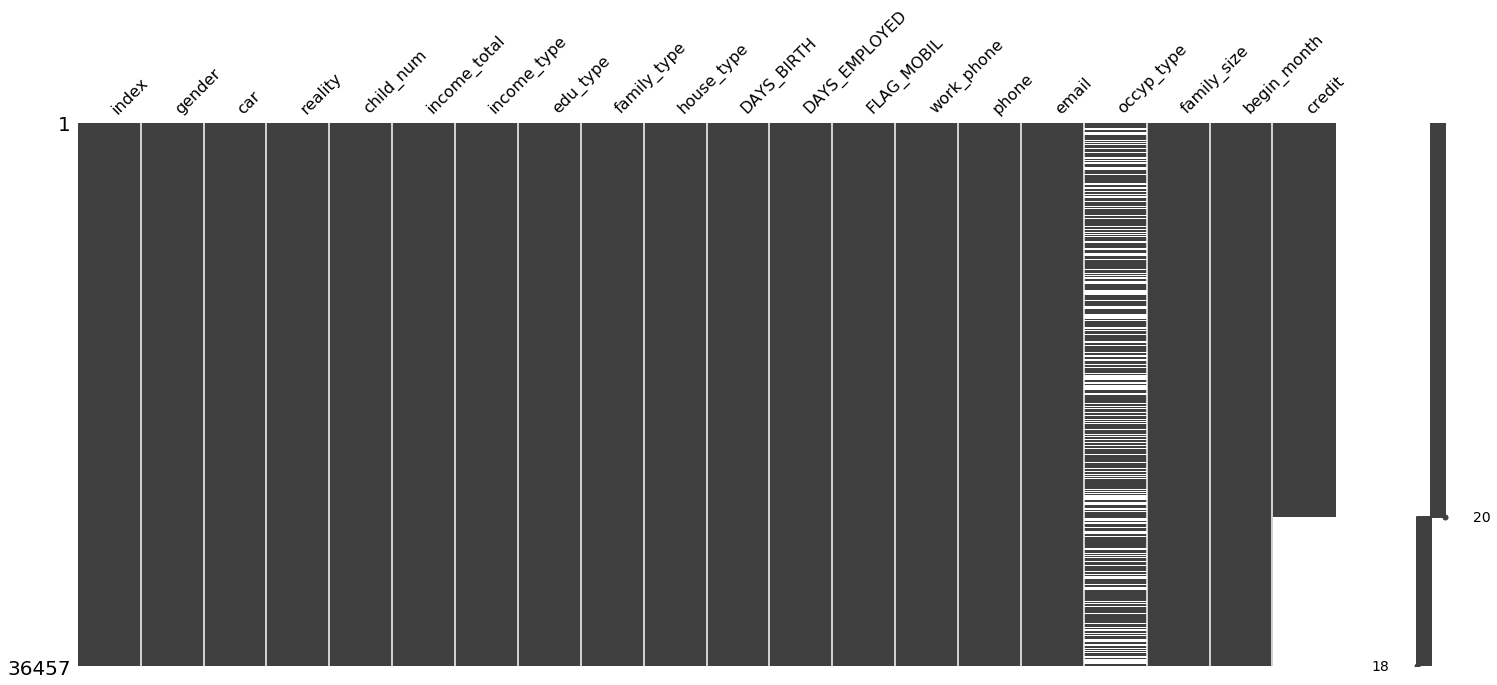

In [8]:
msno.matrix(data);
#missing values on occpy_type, which is one of the importants...... -_-; 

### 2.1 Distribution of Target variable 

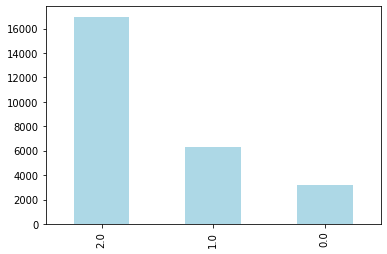

In [9]:
train['credit'].value_counts().plot(kind='bar', color='lightblue', label = 'Train');

# 2> 1> 0   ... 0일수록 신용등급 좋음! 

### 2.2 Distribution of the other variables & Labeling

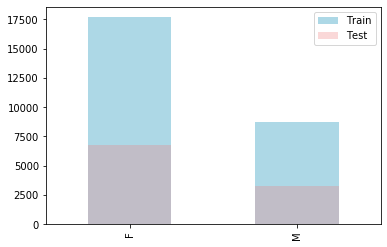

In [10]:
train['gender'].value_counts().plot(kind='bar', color='lightblue', label = 'Train')
test['gender'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();
# Female > Male, train에서 그 갭차이가 더 있음. 
# 결혼여부, 연령대랑 같이 봐야 할듯. 

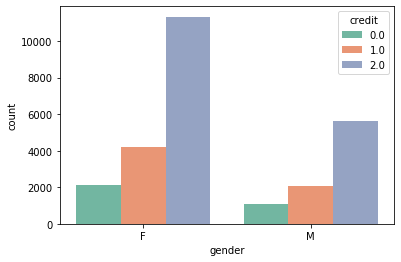

In [11]:
sns.countplot(train['gender'], hue=train['credit'], palette='Set2');

In [48]:
data['gender'].replace('M', 0, inplace=True)
data['gender'].replace('F', 1, inplace=True)

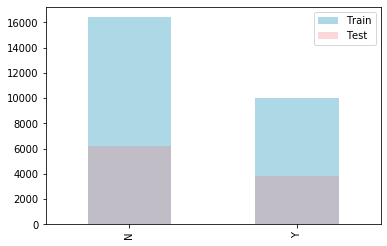

In [13]:
train['car'].value_counts().plot(kind='bar', color='lightblue', label = 'Train')
test['car'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

# No car > car   차를 소유 했는지... 차를 몰 경제적 여유가 있다는 건가..? 꼭 안그럴수도 있을 듯 함. 
# 이 피처는 상관관계 분석 후 제외해 보는 쪽으로 생각하자. 

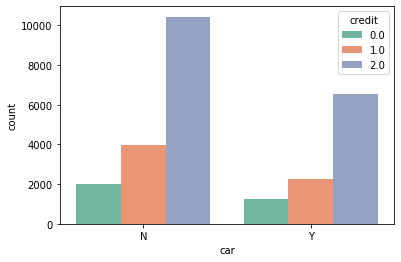

In [14]:
sns.countplot(train['car'],hue=train['credit'], palette='Set2');

In [49]:
data['car'].replace('N', 0, inplace=True)
data['car'].replace('Y', 1, inplace=True)

# 차 = assets. 

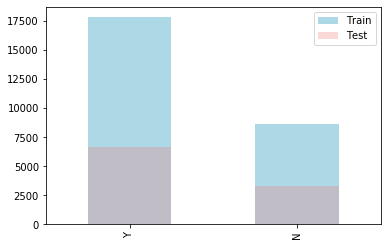

In [16]:
train['reality'].value_counts().plot(kind='bar', color='lightblue', label = 'Train')
test['reality'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

# reality > no reality 

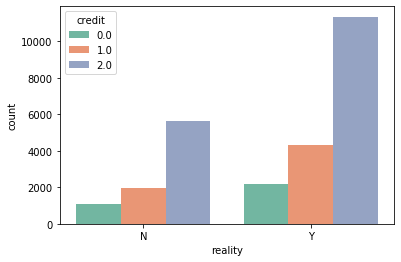

In [17]:
sns.countplot(train['reality'],hue=train['credit'],palette='Set2');
#housepoor?! 


In [50]:
data['reality'].replace('N', 0, inplace=True)
data['reality'].replace('Y', 1, inplace=True)

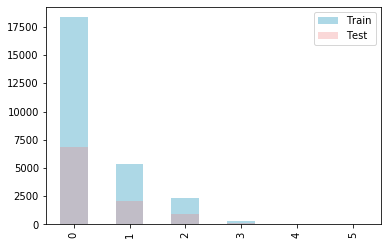

In [19]:
train['child_num'].value_counts().plot(kind='bar', color='lightblue', label = 'Train')
test['child_num'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

# 아이 = 지출 

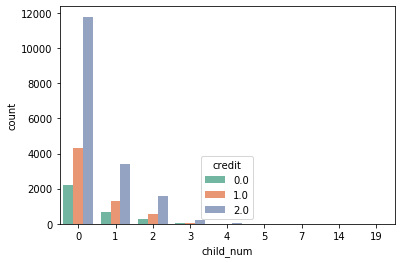

In [20]:
sns.countplot(train['child_num'],hue=train['credit'],palette='Set2');

# family size, child num 


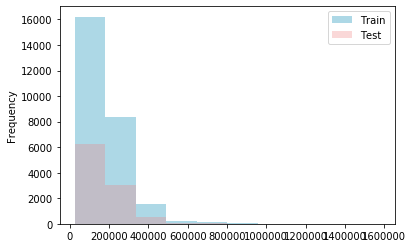

In [21]:
train['income_total'].plot(kind='hist', color='lightblue', label = 'Train')
test['income_total'].plot(kind='hist', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();
# 상대적 지표 
#소득이 높을수록 당연히 신용등급이 좋지 않을까? 

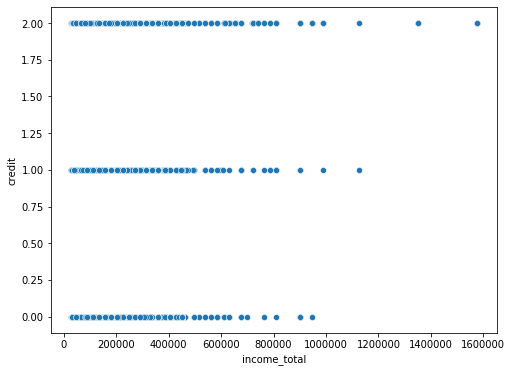

In [22]:
var = 'income_total'
temp = pd.concat([train['credit'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x=var, y="credit", data=temp);

# 소득이 높은 사람들 중에서도 연체하는 사람들이 있다. 
# 일반적이지 않은 경우이니 추가적으로 살펴볼 필요 있을듯 
# 구간 .. 3, 5개, ~~ ? 

In [84]:
# data['income_total_split']=pd.cut(data['income_total'], 10)
data['income_total_split']=pd.qcut(data['income_total'], 9)

In [85]:
data['income_total_split'].value_counts()

(112500.0, 135000.0]     5871
(26999.999, 90000.0]     4479
(90000.0, 112500.0]      4123
(135000.0, 157500.0]     4090
(157500.0, 180000.0]     3897
(292500.0, 1575000.0]    3885
(225000.0, 292500.0]     3884
(202500.0, 225000.0]     3513
(180000.0, 202500.0]     2715
Name: income_total_split, dtype: int64

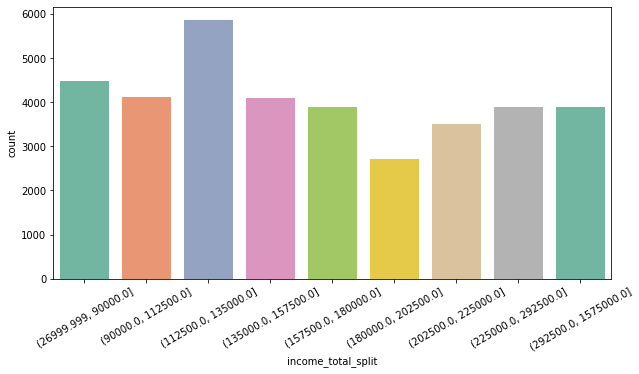

In [87]:
fig, ax=plt.subplots(figsize=(10,5))
sns.countplot(data['income_total_split'], palette='Set2')
plt.xticks(rotation=30);

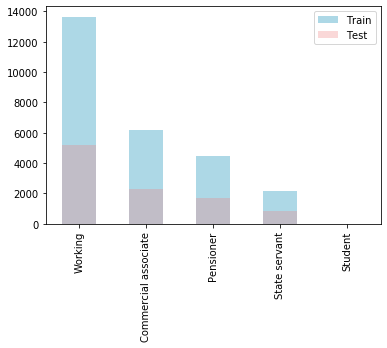

--- 신분?직업? ---
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: income_type, dtype: int64



In [25]:
train['income_type'].value_counts().plot(kind='bar', color='lightblue', label = 'Train')
test['income_type'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

print('--- 신분?직업? ---')
print(data.income_type.value_counts())
print()

# 이 피처는 좀 정돈을 해야할듯. 
# working이 정확히 월급쟁이인가? 그렇다면 state servant랑 묶어야 할 것 같음.
# commercial associate의 경우 아마 자영업자 같음? 
# pensioner 은퇴층인것 같고 
# Student 학생. -> 소득을 좀 같이 봐야할듯. 
# occyp_type이랑 같이봐야할듯. 

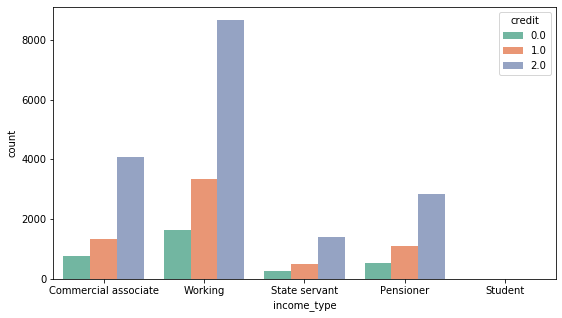

In [26]:
fig = plt.figure(figsize=(9,5))
sns.countplot(train['income_type'],hue=train['credit'],palette='Set2')
plt.show();

In [27]:
data.occyp_type.isnull().sum()

11323

In [28]:
temp1=pd.pivot_table(train, index=['income_type', 'occyp_type'], values='index', aggfunc=np.count_nonzero)
temp2=pd.pivot_table(test, index=['income_type', 'occyp_type'], values='index', aggfunc=np.count_nonzero)

pd.set_option('max_columns',500)
print('='*80)
print('TRAIN : Income_type and Occupation')
print('='*80)
print(temp1)
print()
print('='*80)
print(' TEST : Income_type and Occupation')
print('='*80)
print(temp2)

# occyp_type .. 2nd 
# income_type 

TRAIN : Income_type and Occupation
                                            index
income_type          occyp_type                  
Commercial associate Accountants              363
                     Cleaning staff            80
                     Cooking staff             92
                     Core staff               609
                     Drivers                  418
                     HR staff                  21
                     High skill tech staff    306
                     IT staff                  15
                     Laborers                1075
                     Low-skill Laborers        33
                     Managers                 846
                     Medicine staff           127
                     Private service staff     96
                     Realty agents             43
                     Sales staff              860
                     Secretaries               14
                     Security staff           138
               

In [53]:
# 보아하니 occyp_type 은 널값도 많고 세부적이지 않아서 그냥 income_type만 픽하는게 좋을듯? 
# commercial associate + student -> 0 (계약직?)
# pensioner + state servant + working -> 1 (고정)

# data['income_type'].replace(['Commercial Associate', 'Students'], 0, inplace=True)
# data['income_type'].replace(['Working', 'Pensioner', 'State servant'], 1, inplace=True)

#labeling
cat_cols=['income_type']
lbl = LabelEncoder()
for col in tqdm( cat_cols ):   
    lbl.fit( data[col] )
    data[col]=lbl.transform(data[col])

  0%|          | 0/1 [00:00<?, ?it/s]

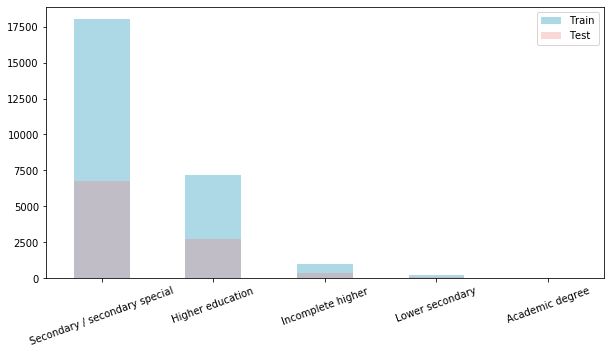

In [30]:
plt.figure(figsize=(10,5))
train['edu_type'].value_counts().plot(kind='bar', color='lightblue', label = 'Train')
test['edu_type'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.xticks(rotation=20)
plt.show();

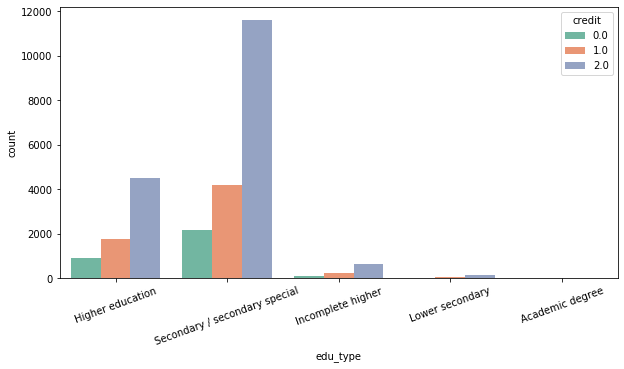

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(train['edu_type'],hue=train['credit'],palette='Set2')
plt.xticks(rotation=20);


In [32]:
# lower secondary = 중졸 미만 
# secondary = 12~18 .. 중졸~고졸 

# incompelete higher = 전문대 ? 
# higher education = 대졸 ?
# academic degree = 대졸 

data['edu_type'].replace(['Lower secondary','Secondary / secondary special'], 0, inplace=True)
data['edu_type'].replace(['Incomplete higher','Higher education', 'Academic degree'], 1, inplace=True)

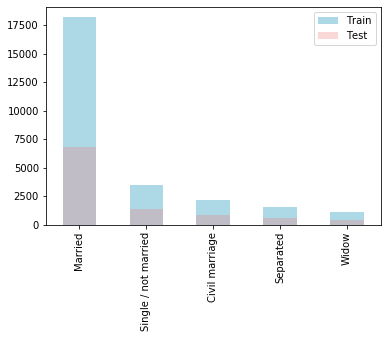

In [33]:
train['family_type'].value_counts().plot(kind='bar', color='lightblue', label = 'Train')
test['family_type'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

# married, civil marriage -> married 
# single # separated, widow ..? -> single 

In [54]:
data['family_type'].replace(['Married','Civil marriage'], 0, inplace=True)
data['family_type'].replace(['Single / not married', 'Separated', 'Widow'], 1, inplace=True)

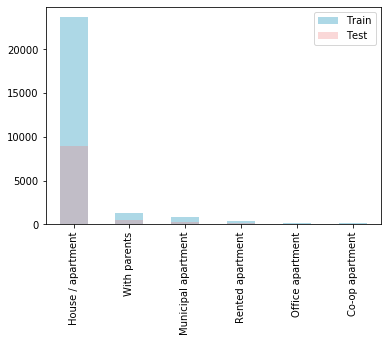

In [35]:
train['house_type'].value_counts().plot(kind='bar', color='lightblue', label = 'Train')
test['house_type'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

# 굳이 이렇게 자세하게 나눌 필요가? 이 피처는 제외하는 걸로 고려해 봐야겠다. 
# 제외! 
# 부양가족 fam_size, child+ house => 부양가족 있냐 없냐 

In [55]:
data.child_num.value_counts()

0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: child_num, dtype: int64

In [65]:
# 부양 가족 여부에 대한 feature : child + parents -> child_parents
data['child']=data['child_num'].apply(lambda x : 1 if x>0 else 0)
data['parents'] = data['house_type'].apply(lambda x : 1 if x=='With parents' else 0)
data['child_parents']=data['child']+data['parents']
data['child_parents'].value_counts()
# 0 = 부양가가족없음  
# 1 = 아이 또는 부모 
# 2 = 아이 부모 둘다. 

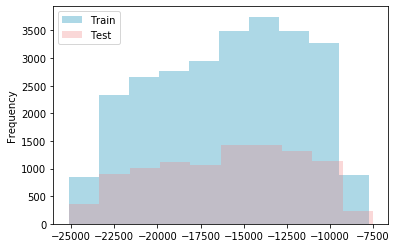

In [69]:
train['DAYS_BIRTH'].plot(kind='hist', color='lightblue', label='Train')
test['DAYS_BIRTH'].plot(kind='hist', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

In [71]:
print(f'데이터 수집일 기준 가장 어린 나이 : {abs(data["DAYS_BIRTH"].max()/365)}')
print(f'데이터 수집일 기준 가장 많은 나이 : {abs(data["DAYS_BIRTH"].min()/365)}')

데이터 수집일 기준 가장 어린 나이 : 20.517808219178082
데이터 수집일 기준 가장 많은 나이 : 68.90958904109588


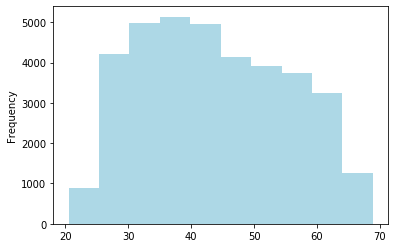

In [88]:
# 나이 계산
data['Age'] = round(abs(data["DAYS_BIRTH"]/365),1)
data['Age'].plot(kind='hist', color='lightblue');

# 구간 나누기 

In [89]:
data['Age_split']=pd.cut(data['Age'],10)

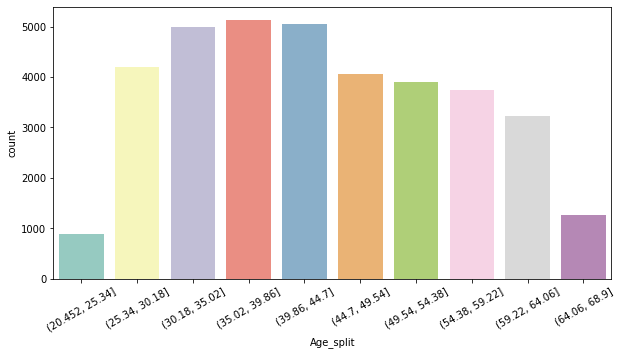

In [93]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data['Age_split'], palette='Set3')
plt.xticks(rotation=30);

In [94]:
print('--- UNEMPLOYED ---')
print(f'train data : {(train.DAYS_EMPLOYED>0).sum()}')
print(f'test data : {(test.DAYS_EMPLOYED>0).sum()}')
print()
print('--- EMPLOYED ---')
print(f'train data : {(train.DAYS_EMPLOYED<0).sum()}')
print(f'test data : {(test.DAYS_EMPLOYED<0).sum()}')

--- UNEMPLOYED ---
train data : 4438
test data : 1697

--- EMPLOYED ---
train data : 22019
test data : 8303


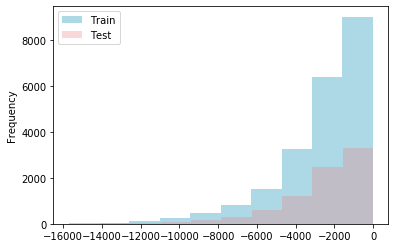

In [95]:
employed_train = train[train['DAYS_EMPLOYED'] <0]
employed_test = test[test['DAYS_EMPLOYED'] <0]

employed_train['DAYS_EMPLOYED'].plot(kind='hist', color='lightblue', label='Train')
employed_test['DAYS_EMPLOYED'].plot(kind='hist', color='lightcoral' , alpha=0.3, label='Test')
plt.legend()
plt.show();

#비교적 최근에 취직해서 카드 발급한 사람이 많음 

In [97]:
#고용되지 않은 사람들의 고용기간을 0으로 바꿈. 
# print(len(data['DAYS_EMPLOYED']>0))
# print(len(data['DAYS_EMPLOYED']==365243))
data['DAYS_EMPLOYED'].replace(365243, 0, inplace=True)
# data['DAYS_EMPLOYED'].max()

count    36457.000000
mean         6.028266
std          6.484375
min          0.000000
25%          1.117808
50%          4.252055
75%          8.638356
max         43.049315
Name: DAYS_EMPLOYED_re, dtype: float64


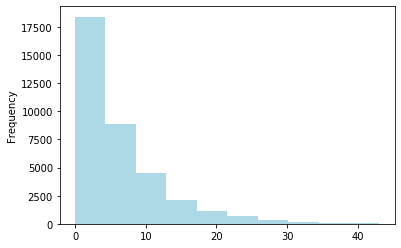

In [98]:
data['DAYS_EMPLOYED_re'] = abs(data['DAYS_EMPLOYED']/365)
data['DAYS_EMPLOYED_re'].plot(kind='hist', color='lightblue');
print(data['DAYS_EMPLOYED_re'].describe())

# 구간? 
# 데이터 수집일 기준 

In [107]:
data['DAYS_EMPLOYED_split']=pd.cut(data['DAYS_EMPLOYED_re'],15)

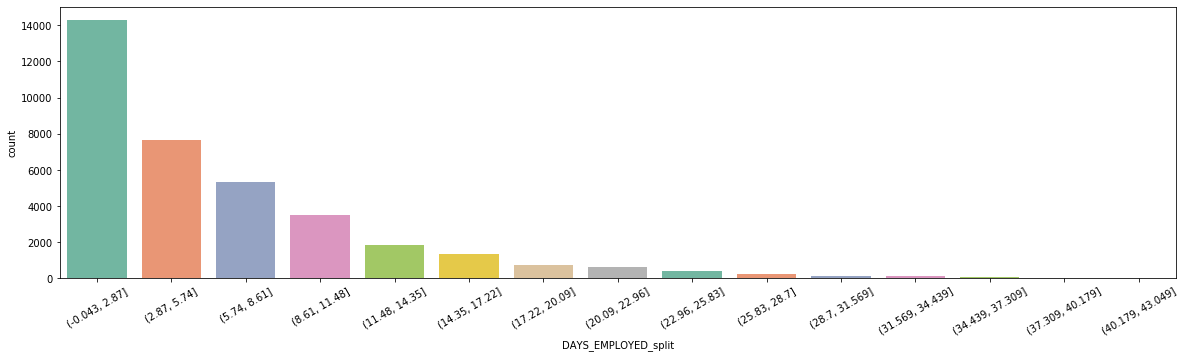

In [108]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(data['DAYS_EMPLOYED_split'], palette='Set2')
plt.xticks(rotation=30);

In [ ]:
display(data.FLAG_MOBIL.sum())
display(train.shape[0]+test.shape[0])
# mobile 제외해도 될듯. 

In [ ]:
display(data.work_phone.sum())
display(data.phone.sum())
display(train.shape[0]+test.shape[0])
# 전화를 소유했는지 여부는 별로 중요하지 않을 것 같음. 
# 따라서 FLAG_MOBIL, work_phone, phone 은 제외해도 될 듯. 

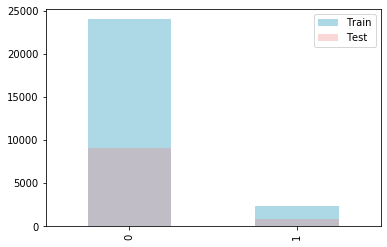

In [109]:
train['email'].value_counts().plot(kind='bar', color='lightblue', label='Train')
test['email'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();
#이메일이 없다는 건, 그만큼 사회생활을 안한다는 얘기 or 나이가 많아 그런걸 잘 모른다는 얘기. 

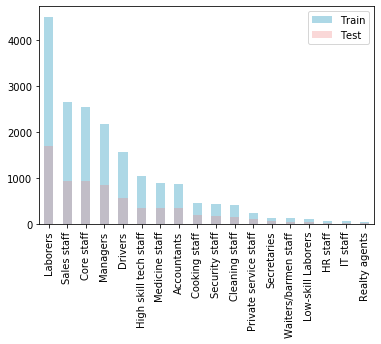

In [110]:
train['occyp_type'].value_counts().plot(kind='bar', color='lightblue', label='Train')
test['occyp_type'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

# income_type과 함께 feature engineering 할 필요 있음. 
# income_total이랑 고소득, 중위소득, 저소득으로 나눌 필요도 있겠음. 
# 어떤 일을 하는게 중요할까..? 이 피처는 어쩌면 중요하지 않을수도. 

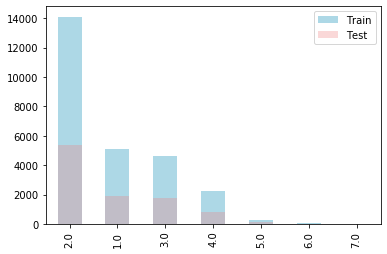

In [111]:
train['family_size'].value_counts().plot(kind='bar', color='lightblue', label='Train')
test['family_size'].value_counts().plot(kind='bar', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

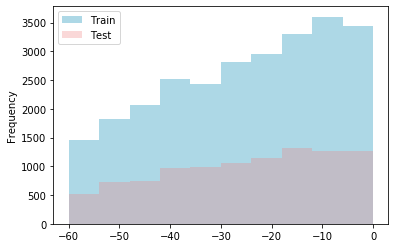

In [112]:
train['begin_month'].plot(kind='hist', color='lightblue', label='Train')
test['begin_month'].plot(kind='hist', color='lightcoral', alpha=0.3, label='Test')
plt.legend()
plt.show();

#최근에 발급받은 사람이 더 많음. 
#카드 발급 기간과 연체 사이에 무슨 상관관계가 있나? 

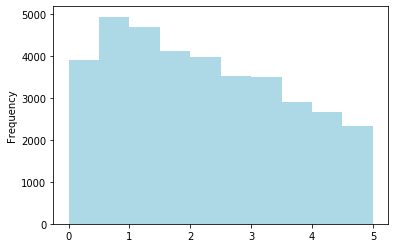

In [113]:
data['begin_month_re']=round(abs(data['begin_month']/12),2)
data['begin_month_re'].plot(kind='hist', color='lightblue');

In [118]:
print(f'가장 최근에 발급받은 일자 : 조사시점 기준 {data["begin_month_re"].min()}개월 전')
print(f'가장 나중에 발급받은 일자 : 조사시점 기준 {data["begin_month_re"].max()}개월 전')

가장 최근에 발급받은 일자 : 조사시점 기준 0.0개월 전
가장 나중에 발급받은 일자 : 조사시점 기준 5.0개월 전


In [114]:
data['begin_month_split']=pd.cut(data['begin_month_re'],10)

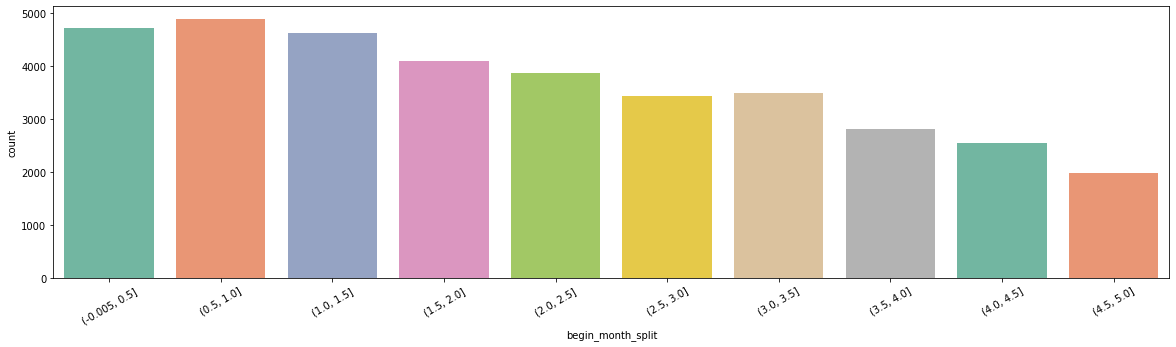

In [115]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(data['begin_month_split'], palette='Set2')
plt.xticks(rotation=30);

In [142]:
data.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit',
       'income_total_split', 'child', 'parents', 'child_parents', 'Age',
       'Age_split', 'DAYS_EMPLOYED_re', 'DAYS_EMPLOYED_split',
       'begin_month_re', 'begin_month_split', 'identity'],
      dtype='object')

In [145]:
drop_cols=['index', 'child_num', 'income_total', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',\
          'FLAG_MOBIL', 'work_phone', 'phone', 'occyp_type', 'begin_month', 'child',\
          'parents', 'Age', 'DAYS_EMPLOYED_re', 'begin_month_re']
target_cols='credit'
final_data=data.drop(drop_cols, 1)

In [147]:
final_data.head()

,gender,car,reality,income_type,edu_type,family_type,email,family_size,credit,income_total_split,child_parents,Age_split,DAYS_EMPLOYED_split,begin_month_split,identity
0,1,0,0,0,Higher education,0,0,2.0,1.0,"(180000.0, 202500.0]",0,"(35.02, 39.86]","(11.48, 14.35]","(-0.005, 0.5]",1202500.00-13899-4709
1,1,0,1,0,Secondary / secondary special,0,1,3.0,1.0,"(225000.0, 292500.0]",1,"(30.18, 35.02]","(2.87, 5.74]","(-0.005, 0.5]",1247500.00-11380-1540
2,0,1,1,4,Higher education,0,0,2.0,2.0,"(292500.0, 1575000.0]",0,"(49.54, 54.38]","(11.48, 14.35]","(1.5, 2.0]",0450000.04-19087-4434
3,1,0,1,0,Secondary / secondary special,0,0,2.0,0.0,"(180000.0, 202500.0]",0,"(39.86, 44.7]","(2.87, 5.74]","(3.0, 3.5]",1202500.00-15088-2092
4,1,1,1,2,Higher education,0,0,2.0,2.0,"(135000.0, 157500.0]",0,"(39.86, 44.7]","(5.74, 8.61]","(2.0, 2.5]",1157500.02-15037-2105


### 2.3 중복 인물 처리?

In [119]:
data['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(data['gender'],data['income_total'],\
                                                                                    data['income_type'],data['DAYS_BIRTH'],data['DAYS_EMPLOYED'])]

In [127]:
data['identity'].value_counts()>1

1297000.00-15519-3234     True
1157500.02-12676-1350     True
0225000.04-16768-3088     True
167500.04-11126-2087      True
1202500.01-211260         True
                         ...  
1153000.01-221780        False
0225000.04-19138-1291    False
1180000.01-239520        False
0135000.00-13556-1615    False
185500.01-205470         False
Name: identity, Length: 9674, dtype: bool

In [156]:
data[data['begin_month']==-37.0].iloc[:, :20]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
3,3,1,0,1,0,202500.0,0,Secondary / secondary special,0,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
18,18,1,0,1,0,216000.0,1,Secondary / secondary special,0,House / apartment,-23113,0,1,0,0,0,NaN,2.0,-37.0,2.0
52,52,1,0,1,0,54000.0,1,Secondary / secondary special,0,House / apartment,-24044,0,1,0,1,0,NaN,2.0,-37.0,2.0
230,230,1,0,0,0,103500.0,4,Secondary / secondary special,0,House / apartment,-17767,-11062,1,1,0,0,Medicine staff,2.0,-37.0,2.0
239,239,1,1,1,1,270000.0,4,Higher education,1,House / apartment,-14052,-140,1,0,1,1,Sales staff,2.0,-37.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9736,36193,1,0,1,2,54000.0,4,Secondary / secondary special,0,House / apartment,-9905,-795,1,0,0,0,Sales staff,4.0,-37.0,NaN
9815,36272,1,0,1,0,112500.0,4,Secondary / secondary special,1,House / apartment,-14491,-1955,1,0,0,0,Sales staff,1.0,-37.0,NaN
9848,36305,0,0,1,0,135000.0,0,Secondary / secondary special,0,House / apartment,-19924,-4822,1,0,0,1,Drivers,2.0,-37.0,NaN
9929,36386,1,0,1,0,144000.0,4,Higher education,1,House / apartment,-13190,-4943,1,0,0,0,NaN,1.0,-37.0,NaN


In [154]:
data[data['identity']=='1297000.00-15519-3234'].iloc[:, :20].sort_values('begin_month')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
19206,19206,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-37.0,1.0
717,717,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-36.0,0.0
19716,19716,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-36.0,0.0
8420,34877,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-34.0,NaN
5168,5168,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-34.0,1.0
2302,28759,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-32.0,NaN
10368,10368,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-31.0,0.0
25796,25796,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-30.0,1.0
21338,21338,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-29.0,0.0
23193,23193,1,0,1,0,297000.0,0,Secondary / secondary special,1,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-27.0,1.0


In [157]:
# 발급받은 날짜가 동일한 사람들을 기준으로 sort 
data[data['begin_month']==-5.0].iloc[:10, :20]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
1,1,1,0,1,1,247500.0,0,Secondary / secondary special,0,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
9,9,1,0,1,0,103500.0,4,Secondary / secondary special,0,House / apartment,-15785,-1308,1,0,0,0,Medicine staff,2.0,-5.0,2.0
24,24,1,0,0,0,202500.0,1,Secondary / secondary special,1,House / apartment,-22361,0,1,0,1,0,NaN,1.0,-5.0,2.0
92,92,0,1,1,1,135000.0,0,Secondary / secondary special,0,House / apartment,-12190,-691,1,0,0,0,Laborers,3.0,-5.0,2.0
98,98,0,1,1,0,450000.0,0,Higher education,1,House / apartment,-10837,-588,1,0,0,1,Sales staff,1.0,-5.0,2.0
105,105,0,1,1,0,135000.0,0,Secondary / secondary special,0,House / apartment,-9984,-2606,1,0,0,0,Laborers,2.0,-5.0,2.0
181,181,1,0,1,0,90000.0,1,Secondary / secondary special,0,House / apartment,-20718,0,1,0,0,0,NaN,2.0,-5.0,0.0
195,195,1,0,1,0,202500.0,4,Secondary / secondary special,0,House / apartment,-10981,-552,1,0,0,0,Laborers,2.0,-5.0,2.0
255,255,1,0,1,1,180000.0,2,Higher education,0,House / apartment,-10969,-3485,1,0,0,1,High skill tech staff,3.0,-5.0,1.0
282,282,0,0,0,0,90000.0,1,Secondary / secondary special,1,House / apartment,-20644,0,1,0,0,0,NaN,1.0,-5.0,2.0


In [122]:
temp=data[data['identity']=='1297000.0Commercial associate-15519-3234']
temp.sort_values(['begin_month'])

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_total_split,child_YN,child,parents,child_parents,Age,Age_split,DAYS_EMPLOYED_re,DAYS_EMPLOYED_split,begin_month_re,begin_month_split,identity


In [123]:
data['identity'].value_counts()==2

1297000.00-15519-3234    False
1157500.02-12676-1350    False
0225000.04-16768-3088    False
167500.04-11126-2087     False
1202500.01-211260        False
                         ...  
1153000.01-221780        False
0225000.04-19138-1291    False
1180000.01-239520        False
0135000.00-13556-1615    False
185500.01-205470         False
Name: identity, Length: 9674, dtype: bool

In [124]:
display(data[data['identity']=='154000.01-240260'])
display(data[data['identity']=='1315000.01-15886-4858'])
display(data[data['identity']=='0135000.01-12807-2404'])

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_total_split,child_YN,child,parents,child_parents,Age,Age_split,DAYS_EMPLOYED_re,DAYS_EMPLOYED_split,begin_month_re,begin_month_split,identity
8067,8067,1,0,1,0,54000.0,1,Secondary / secondary special,1,House / apartment,-24026,0,1,0,1,0,NaN,1.0,-30.0,0.0,"(26999.999, 90000.0]",0,0,0,0,65.8,"(64.06, 68.9]",0.0,"(-0.043, 2.87]",2.5,"(2.0, 2.5]",154000.01-240260


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_total_split,child_YN,child,parents,child_parents,Age,Age_split,DAYS_EMPLOYED_re,DAYS_EMPLOYED_split,begin_month_re,begin_month_split,identity


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_total_split,child_YN,child,parents,child_parents,Age,Age_split,DAYS_EMPLOYED_re,DAYS_EMPLOYED_split,begin_month_re,begin_month_split,identity


### 2.3 Correlation 

In [ ]:
drop_cols=['DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'house_type','work_phone', 'phone', 'begin_month']
data_corr=data.iloc[:, 1:].drop(drop_cols,1).corr()

In [ ]:
# sns.heatmap(data_corr);
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data_corr,  cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

# high correlation : child_num & DAYS_BIRTH, child_num & family_size -> needs triming! 

### 3. 1st Feature Engineering for baseline modeling

In [ ]:
data.iloc[:, 1:].drop(drop_cols,1)